## Import libs

In [1]:
%cd ..

import os
os.environ['CUDA_VISIBLE_DEVICES']='4'

/Users/sashafedorova/jetBrainsIntern/effective-inference


/Users/sashafedorova/jetBrainsIntern/effective-inference/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
!pip install datasets
!pip install transformers
# !pip install utils.prepare_dataset

In [1]:
from datasets import load_dataset

from transformers import AutoTokenizer, AutoModel, GPT2LMHeadModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import torch
from tqdm.auto import tqdm
from prepare_dataset import load_datasets, cut_datasets
from collections import defaultdict
import pickle
import psutil
import pandas as pd
import os
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

/Users/sashafedorova/jetBrainsIntern/effective-inference/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Define hyperparams

In [2]:
# Define datasets
#['mrpc', 'sst2', 'cola', 'rte', 'qnli']
glue_classification = {'mrpc': ['sentence1', 'sentence2']} #, 'sst2':  ['sentence']}
superglue_classification = {'wic': ['sentence1', 'sentence2']}
all_classification = {'glue': glue_classification, 'superglue': superglue_classification}

model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=1024)
model = AutoModel.from_pretrained(model_name)
model.eval()

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

os.environ["TOKENIZERS_PARALLELISM"] = "false"
model.to(device)
DEBUG_FLAG = False
CUT_SIZE = 1000 if not DEBUG_FLAG else 100

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Load datasets

In [3]:
glue_datasets = load_datasets('glue', list(glue_classification), CUT_SIZE)
superglue_datasets = load_datasets('super_glue', list(superglue_classification), CUT_SIZE)

all_datasets = {'glue': glue_datasets, 'superglue': superglue_datasets}

Found cached dataset glue (/Users/sashafedorova/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset super_glue (/Users/sashafedorova/.cache/huggingface/datasets/super_glue/wic/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)


  0%|          | 0/3 [00:00<?, ?it/s]

## Saving-data function

In [4]:
def add_to_pickle_file(file_path, new_results):
    # Load existing data from the file
    try:
        with open(file_path, 'rb') as file:
            existing_data = pickle.load(file)
    except FileNotFoundError:
      existing_data = {}
    except EOFError:
      existing_data = {}

    for l, heads in new_results.items():
        if l not in existing_data:
            existing_data[l] = heads
            continue
        for h, data in heads.items():
            if h not in existing_data[l]:
                existing_data[l][h] = data
            else:
                print(existing_data[l][h])
                print(existing_data[l][h].update(data))
                print(existing_data)
                existing_data[l][h].update(data)

    with open(file_path, 'wb') as file:
        pickle.dump(existing_data, file)

def get_from_pickle_File(file_path):
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except FileNotFoundError:
        return {}
    except EOFError:
        return {}


## Collect dataset for layers and heads

In [99]:
import numpy as np


# layer2head2sample = {}
# sample = ((cur_emb, cur_pos, cur_len, tgt_pos, tgt_len), attention_weight)

for ex in tqdm(glue_datasets['mrpc']['train']):
    encoded_inputs = tokenizer.encode(
                    ex['sentence1'],
                    ex['sentence2'],
                    truncation=True,
                    return_tensors='pt'
                ).to(device)
    aa = model(encoded_inputs, output_hidden_states=True, output_attentions=True)

    for layer in [9]:
        if layer not in layer2head2sample:
            layer2head2sample[layer] = {}
        for head_num in [3, 6]:#range( aa.attentions[0].shape[1]): #
            if head_num not in layer2head2sample[layer]:
                layer2head2sample[layer][head_num] = []
            for from_ in range(aa.attentions[0].shape[2]):
                for to_ in range(aa.attentions[0].shape[3]):
                    cur_emb = aa.hidden_states[layer][0][from_].detach().cpu().numpy()
                    tgt_attention = aa.attentions[layer][0][head_num][from_][to_].detach().cpu().item()
                    layer2head2sample[layer][head_num].append(((cur_emb, from_, aa.attentions[0].shape[2], to_, aa.attentions[0].shape[3]), tgt_attention))


  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
# %%time
# for layer, heads in layer2head2sample.items():
#     for head in tqdm(heads):
#         torch.save(heads[head],f'data/layer{layer}/head{head}.pt', pickle_protocol = 5)

ValueError: 'a' cannot be empty unless no samples are taken

## All variants sample

In [ ]:
results_new = {}
sizes = {}
for layer, heads in layer2head2sample.items():
    if layer not in results_new:
        results_new[layer] = {}
    for head, samples in heads.items():  #range(12):
        if head not in results_new[layer]:
            results_new[layer][head] = {}
        samples_idxs = np.random.choice(range(len(samples)), size=200000, replace=False)

        y_train = np.array([samples[el][1] for el in samples_idxs])

        #embeddings + positions
        X_train_base = np.array([list(samples[el][0][0]) + [samples[el][0][1], samples[el][0][3]] for el in samples_idxs])
        base = cross_val_score(Ridge(), X_train_base, y_train, n_jobs=4, scoring='r2').mean()
        #embeddings + positions + reversed positions
        X_train_rev = np.array([list(samples[el][0][0]) + [samples[el][0][1], samples[el][0][2] - samples[el][0][1], samples[el][0][3], samples[el][0][4] - samples[el][0][3]] for el in samples_idxs])
        rev = cross_val_score(Ridge(), X_train_rev, y_train, n_jobs=4, scoring='r2').mean()
        #embeddings + positions + reversed positions -> scaled
        X_train_scaled = StandardScaler().fit_transform(X_train_rev)
        scaled = cross_val_score(Ridge(), X_train_scaled, y_train, n_jobs=4, scoring='r2').mean()

        results_new[layer][head].update({'base': base, 'rev': rev, 'scaled': scaled})
        sizes.update({'base': (X_train_base.shape, y_train.shape), 'rev': (X_train_rev.shape, y_train.shape), 'scaled': (X_train_scaled.shape, y_train.shape)})

        #positions
        X_train_pos = np.array([[samples[el][0][1], samples[el][0][3]] for el in samples_idxs])
        pos = cross_val_score(Ridge(), X_train_pos, y_train, n_jobs=4, scoring='r2').mean()
        #positions + reversed positions + sentence length
        X_train_len = np.array([[samples[el][0][1], samples[el][0][2] - samples[el][0][1],samples[el][0][2], samples[el][0][3], samples[el][0][4] - samples[el][0][3], samples[el][0][4]] for el in samples_idxs])
        l = cross_val_score(Ridge(), X_train_len, y_train, n_jobs=4, scoring='r2').mean()
        #positions + reversed positions + sentence length -> scaled
        X_train_scaled_pos = StandardScaler().fit_transform(X_train_len)
        scaled_pos = cross_val_score(Ridge(), X_train_scaled_pos, y_train, n_jobs=4, scoring='r2').mean()

        results_new[layer][head].update({'pos': pos, 'len': l, 'scaled_pos': scaled_pos})
        sizes.update({'pos': (X_train_pos.shape, y_train.shape), 'len': (X_train_len.shape, y_train.shape), 'scaled_pos': (X_train_scaled_pos.shape, y_train.shape)})

        #positions + reversed positions + sentence length + embedding
        X_train_len_emb = np.array([list(samples[el][0][0])+[samples[el][0][1], samples[el][0][2] - samples[el][0][1], samples[el][0][2], samples[el][0][3], samples[el][0][4] - samples[el][0][3], samples[el][0][4]] for el in samples_idxs])
        len_emb = cross_val_score(Ridge(), X_train_len_emb, y_train, n_jobs=4, scoring='r2').mean()
        #positions + reversed positions + sentence length + embedding -> scaled
        X_train_scaled = StandardScaler().fit_transform(X_train_len_emb)
        len_emb_scaled = cross_val_score(Ridge(), X_train_scaled, y_train, n_jobs=4, scoring='r2').mean()


        results_new[layer][head].update({'len_emb': len_emb, 'len_emb_scaled': len_emb_scaled})
        sizes.update({'len_emb': (X_train_len_emb.shape, y_train.shape), 'len_emb_scaled': (len_emb_scaled.shape, y_train.shape)})

        #positions + reversed positions + sentence length + relative positions
        X_train_relative_position = np.array([[samples[el][0][1]/samples[el][0][2], samples[el][0][1], samples[el][0][2] - samples[el][0][1], samples[el][0][2], samples[el][0][3]/samples[el][0][4], samples[el][0][4] - samples[el][0][3], samples[el][0][4]] for el in samples_idxs])
        relative_position = cross_val_score(Ridge(), X_train_relative_position, y_train, n_jobs=4, scoring='r2').mean()

        #adding polynomials with degree 2,3,4 to positions + reversed positions + sentence length + relative positions
        X_poly2 = PolynomialFeatures(degree=2).fit_transform(X_train_relative_position)
        X_poly3 = PolynomialFeatures(degree=3).fit_transform(X_train_relative_position)
        X_poly4 = PolynomialFeatures(degree=4).fit_transform(X_train_relative_position)


        poly2 = cross_val_score(Ridge(), X_poly2, y_train, n_jobs=4, scoring='r2').mean()
        poly3 = cross_val_score(Ridge(), X_poly3, y_train, n_jobs=4, scoring='r2').mean()
        poly4 = cross_val_score(Ridge(), X_poly4, y_train, n_jobs=4, scoring='r2').mean()
        results_new[layer][head].update({'relative_position': relative_position, 'poly2': poly2, 'poly3':poly3, 'poly4':poly4})
        sizes.update({'relative_position': (X_train_relative_position.shape, y_train.shape), 'poly2': (X_poly2.shape, y_train.shape), 'poly3':(X_poly3.shape, y_train.shape), 'poly4':(X_poly4.shape, y_train.shape)})

        print(f'layer {layer} head {head} :')
        print(f'{results_new[layer][head]}')

## Saving results

In [ ]:
name = 'results.pickle'
add_to_pickle_file(name, results_new)
# get_from_pickle_File(name)

In [14]:
res = get_from_pickle_File('results.pickle')
res

## Analyse

In [11]:
name = '/Users/sashafedorova/jetBrainsIntern/effective-inference/utils/results.pickle'
result = get_from_pickle_File(name)

In [20]:
sizes

{'base': ((200000, 770), (200000,)),
 'rev': ((200000, 772), (200000,)),
 'scaled': ((200000, 772), (200000,)),
 'pos': ((200000, 2), (200000,)),
 'len': ((200000, 6), (200000,)),
 'scaled_pos': ((200000, 6), (200000,)),
 'len_emb': ((200000, 774), (200000,)),
 'X_train_scaled': ((200000, 774), (200000,)),
 'relative_position': ((200000, 7), (200000,)),
 'poly2': ((200000, 36), (200000,)),
 'poly3': ((200000, 120), (200000,)),
 'poly4': ((200000, 330), (200000,))}

In [ ]:
# from statistics import mean
# test = {}
# # lst = ['base', 'rev', 'scaled', 'pos', 'len', 'scaled_pos', 'len_emb', 'len_emb_scaled', 'relative_position', 'poly2', 'poly3', 'poly4', 'poly5']
# lst = ['pos',  'len',  'relative_position', 'poly2', 'poly3', 'poly4', 'poly5']
# for i in lst: test[i] = []
# layer = 9
#
# for head, data in result[layer].items():
#     for name in lst:
#         if name in data:
#             test[name].append(data[name])
#         elif name in test.keys(): test.pop(name)
#
# for i, data in test.items():
#     test[i] = mean(data)
#
# plt.bar(list(test.keys()), list(test.values()))
# plt.xticks(list(test.keys()), rotation=90)
# plt.title(f'Mean r2 scores for layer {layer}')
# None

In [27]:
# Convert the nested dictionary to a pandas DataFrame
df = pd.DataFrame.from_dict(result[9])
# Display the DataFrame as a table
df.head(16)

,0,1,2,3,4,5,6,7,8,9,10,11
base,0.006259,0.004311,0.002884,0.014647,0.010656,0.003203,0.006620,0.007960,0.001177,0.013771,0.009265,0.009375
rev,0.009366,0.007082,0.006929,0.018894,0.014333,0.007473,0.010333,0.011031,0.005273,0.017798,0.013368,0.014438
scaled,0.009366,0.007082,0.006929,0.018894,0.014333,0.007473,0.010333,0.011031,0.005272,0.017798,0.013368,0.014438
pos,0.006053,0.004997,0.002338,0.012673,0.010398,0.001786,0.005067,0.007517,0.000968,0.013081,0.007664,0.005758
len,0.014864,0.013201,0.011297,0.023679,0.019832,0.011877,0.013967,0.014579,0.009540,0.022228,0.017933,0.017718
scaled_pos,0.014864,0.013201,0.011297,0.023679,0.019832,0.011877,0.013967,0.014579,0.009540,0.022228,0.017933,0.017718
len_emb,0.010658,0.007748,0.006788,0.017982,0.014002,0.007322,0.009881,0.010927,0.005379,0.016475,0.012390,0.012290
len_emb_scaled,0.010657,0.007747,0.006788,0.017982,0.014002,0.007322,0.009881,0.010927,0.005379,0.016475,0.012390,0.012289
relative_position,0.018116,0.015340,0.011703,0.027121,0.022413,0.013831,0.016742,0.018106,0.012095,0.027036,0.020508,0.021426
poly2,0.022308,0.027118,0.023738,0.036479,0.031243,0.015942,0.030356,0.025286,0.020645,0.033625,0.029209,0.038722


In [53]:
result9 = {}
result9['description'] = {}
for head, data in result[9].items():
  result9[head] = {}
  for i, descriptions in {'base': "positions + embedding", 'pos': "positions + reversed positions", 'rev': "'pos' + embeddings", 'scaled': "'rev' scaled"  , 'len': "'pos'+ sentence length",'scaled_pos': "'len' scaled", 'len_emb':"'len' + embeddings",'relative_position': " 'len' + relative positions", 'poly2': "polynomials 2 degree of 'relative_position'", 'poly3':"polynomials 3 degree of 'relative_position'", 'poly4':"polynomials 2 degree of 'relative_position'", 'poly5':"polynomials 2 degree of 'relative_position'"}.items():
    result9[head].update({i: result[9][head][i]})
    result9['description'][i] = descriptions
df = pd.DataFrame.from_dict(result9)

# Display the DataFrame as a table
df.head(20)

,description,0,1,2,3,4,5,6,7,8,9,10,11
base,positions + embedding,0.006259,0.004311,0.002884,0.014647,0.010656,0.003203,0.006620,0.007960,0.001177,0.013771,0.009265,0.009375
pos,positions + reversed positions,0.006053,0.004997,0.002338,0.012673,0.010398,0.001786,0.005067,0.007517,0.000968,0.013081,0.007664,0.005758
rev,'pos' + embeddings,0.009366,0.007082,0.006929,0.018894,0.014333,0.007473,0.010333,0.011031,0.005273,0.017798,0.013368,0.014438
scaled,'rev' scaled,0.009366,0.007082,0.006929,0.018894,0.014333,0.007473,0.010333,0.011031,0.005272,0.017798,0.013368,0.014438
len,'pos'+ sentence length,0.014864,0.013201,0.011297,0.023679,0.019832,0.011877,0.013967,0.014579,0.009540,0.022228,0.017933,0.017718
scaled_pos,'len' scaled,0.014864,0.013201,0.011297,0.023679,0.019832,0.011877,0.013967,0.014579,0.009540,0.022228,0.017933,0.017718
len_emb,'len' + embeddings,0.010658,0.007748,0.006788,0.017982,0.014002,0.007322,0.009881,0.010927,0.005379,0.016475,0.012390,0.012290
relative_position,'len' + relative positions,0.018116,0.015340,0.011703,0.027121,0.022413,0.013831,0.016742,0.018106,0.012095,0.027036,0.020508,0.021426
poly2,polynomials 2 degree of 'relative_position',0.022308,0.027118,0.023738,0.036479,0.031243,0.015942,0.030356,0.025286,0.020645,0.033625,0.029209,0.038722
poly3,polynomials 3 degree of 'relative_position',0.054449,0.054525,0.040055,0.078335,0.068022,0.042578,0.053186,0.059614,0.035740,0.075061,0.058964,0.070754


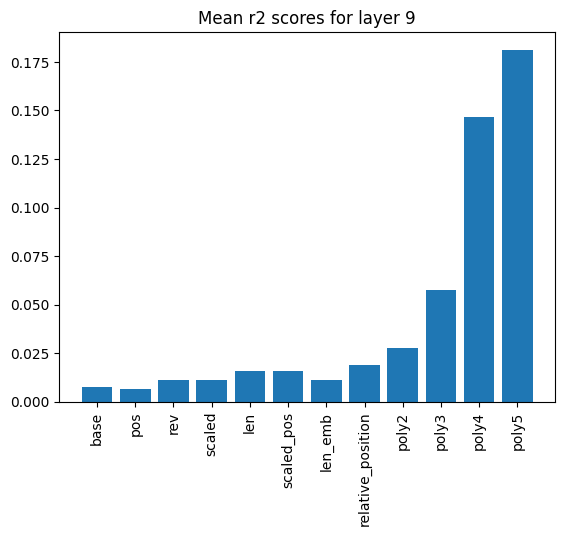

In [76]:
from statistics import mean
import matplotlib.pyplot as plt

scores = {}
for head, score in result9.items():
    if head != 'description':
        for name, s in score.items():
            if name not in scores:
                scores[name] = []
            scores[name].append(s)
for name, s in scores.items():
    scores[name] = mean(s)

plt.bar(list(scores.keys()), list(scores.values()))
plt.xticks(list(scores.keys()), rotation=90)
plt.title('Mean r2 scores for layer 9')
None

## For each head

/var/folders/qp/h1zlfvy13szgps2dksx_2hwc0000gn/T/ipykernel_3705/3001717151.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dfs, rotation=90)


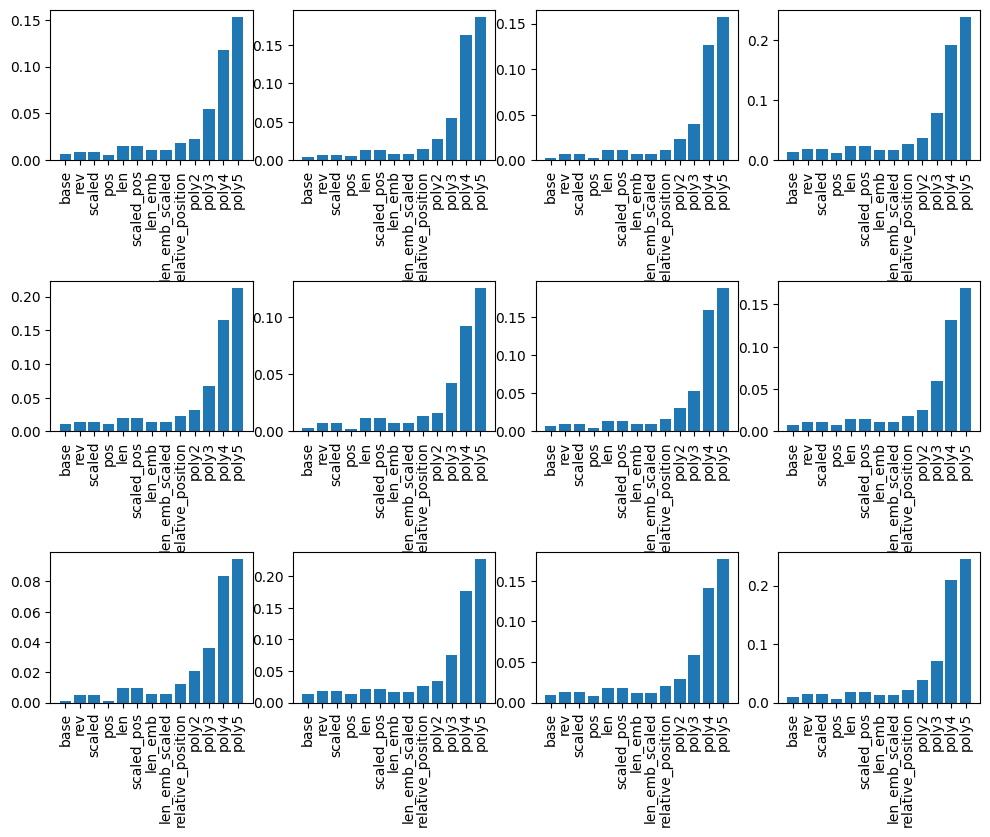

In [78]:
import matplotlib.pyplot as plt


# Extract the data for each head
head_scores = {}
for layer in [9]:
    for head, score_dict in result[layer].items():
        if head not in head_scores:
            head_scores[head] = {}
        for df, score in score_dict.items():
            if df not in head_scores[head]:
                head_scores[head][df] = []
            head_scores[head][df].append(score)

fig, axes = plt.subplots(3, 4, figsize = (12, 9))
# Create bar plots for each head
for head, score_dict in head_scores.items():
    dfs = list(score_dict.keys())
    scores = [sublist[0] for sublist in list(score_dict.values())]

    # Set the width of the bars
    bar_width = 0.15

    # Set the x positions of the bars
    r = range(len(dfs))
    ax = axes[head//4, head%4]
    # Create a bar plot
    ax.bar(dfs, scores)
    # for i, score in enumerate(scores):
    #     ax.bar([x + i * bar_width for x in r], score, bar_width, label=dfs[i])

    # Customize the plot
    # ax.set_xlabel('Dataframes')
    # ax.set_ylabel('Score')
    # ax.set_title(f'Scores for Head {head}')
    ax.set_xticklabels(dfs, rotation=90)
plt.subplots_adjust(hspace=0.8, wspace= 0.2)
    # Show the plot
plt.show()

## Bad ideas

### scale target

In [104]:
results_new = {}
for layer, heads in layer2head2sample.items():
    if layer not in results_new:
        results_new[layer] = {}
    for head, samples in heads.items():
        if head not in results_new[layer]:
            results_new[layer][head] = {}
        # samples = heads[head]
        samples_idxs = np.random.choice(range(len(samples)-2000), size=20000, replace=False)

        X_train_relative_position = np.array([[samples[el][0][1]/samples[el][0][2], samples[el][0][1], samples[el][0][2] - samples[el][0][1], samples[el][0][2], samples[el][0][3]/samples[el][0][4], samples[el][0][4] - samples[el][0][3], samples[el][0][4]] for el in samples_idxs])

        X_train_scaled_emb = StandardScaler().fit_transform(np.array([list(samples[el][0][0])+[samples[el][0][1]/samples[el][0][2], samples[el][0][1], samples[el][0][2] - samples[el][0][1], samples[el][0][2], samples[el][0][3]/samples[el][0][4], samples[el][0][4] - samples[el][0][3], samples[el][0][4]] for el in samples_idxs]))
        y_train = np.array([samples[el][1] for el in samples_idxs])

        # Fit the scaler on the training target variable
        y_train_scaled = StandardScaler().fit_transform(y_train.reshape(-1, 1)).flatten()


        print(f'layer {layer} head {head} :')

        relative_position = cross_val_score(Ridge(), X_train_relative_position, y_train, n_jobs=4, scoring='r2').mean()
        scaled_target = cross_val_score(Ridge(), X_train_relative_position, y_train_scaled, n_jobs=4, scoring='r2').mean()
        scaled_target_emb = cross_val_score(Ridge(), X_train_scaled_emb, y_train_scaled, n_jobs=4, scoring='r2').mean()

        results_new[layer][head].update({ 'scaled_target': scaled_target})#, 'poly6': poly6})
        print(f'relative_position: {relative_position}, scaled_target : {scaled_target}, scaled_target_emb : {scaled_target_emb}')

layer 9 head 0 :
relative_position: 0.019016175109010235, scaled_target : 0.019016175109010415, scaled_target_emb : -0.02877396062685591
layer 9 head 3 :
relative_position: 0.028598339438405618, scaled_target : 0.028598339438405552, scaled_target_emb : -0.021809197829192994
layer 9 head 6 :
relative_position: 0.015936960904576615, scaled_target : 0.015936960904576525, scaled_target_emb : -0.030399161903349414


### relative distance

In [89]:
results_new = {}
for layer, heads in layer2head2sample.items():
    if layer not in results_new:
        results_new[layer] = {}
    for head in [0, 6, 9]:
        if head not in results_new[layer]:
            results_new[layer][head] = {}
        samples = heads[head]
        samples_idxs = np.random.choice(range(len(samples)-2000), size=20000, replace=False)

        X_train_relative_position = np.array([[samples[el][0][1]/samples[el][0][2], samples[el][0][1], samples[el][0][2] - samples[el][0][1], samples[el][0][2], samples[el][0][3]/samples[el][0][4], samples[el][0][4] - samples[el][0][3], samples[el][0][4]] for el in samples_idxs])
        y_train = np.array([samples[el][1] for el in samples_idxs])

        X_train_relative_distance = np.array([[(samples[el][0][1] - samples[el][0][3])/samples[el][0][2], samples[el][0][1]/samples[el][0][2], samples[el][0][1], samples[el][0][2] - samples[el][0][1], samples[el][0][2], samples[el][0][3]/samples[el][0][4], samples[el][0][4] - samples[el][0][3], samples[el][0][4]] for el in samples_idxs])
        relative_distance = cross_val_score(Ridge(), X_train_relative_distance, np.array([samples[el][1] for el in samples_idxs]), n_jobs=4, scoring='r2').mean()

        print(f'layer {layer} head {head} :')

        relative_position = cross_val_score(Ridge(), X_train_relative_position, y_train, n_jobs=4, scoring='r2').mean()

        results_new[layer][head].update({ 'relative_distance': relative_distance})#, 'poly6': poly6})
        print(f'{relative_position}, {relative_distance}')

layer 9 head 0 :
0.019355844609503414, 0.01935490037242644
layer 9 head 6 :
0.01524861173442893, 0.015246804732865793
layer 9 head 9 :
0.025610831567763205, 0.025605219847404027


### get most significant envedding values - not working

In [69]:
from statistics import mean, median, stdev, variance
results_new = {}
for layer, heads in layer2head2sample.items():
    if layer not in results_new:
        results_new[layer] = {}
    for head in [0]:
        if head not in results_new[layer]:
            results_new[layer][head] = {}
        samples = heads[head]
        samples_idxs = np.random.choice(range(len(samples)-2000), size=20000, replace=False)
        samples_idxs2 = np.random.choice(range(len(samples)-2000, len(samples)), size=2000, replace=False)
        X_train_relative_position = np.array([[samples[el][0][1]/samples[el][0][2], samples[el][0][1], samples[el][0][2] - samples[el][0][1], samples[el][0][2], samples[el][0][3]/samples[el][0][4], samples[el][0][4] - samples[el][0][3], samples[el][0][4]] for el in samples_idxs2])

        y_train = np.array([samples[el][1] for el in samples_idxs])
        res9_6 = {}
        # print(len(samples[0][0][0]))
        for i in tqdm(range(len(samples[0][0][0]))):
                X_train_stats = np.array([[samples[el][0][0][i], samples[el][0][1]/samples[el][0][2], samples[el][0][1], samples[el][0][2] - samples[el][0][1], samples[el][0][2], samples[el][0][3]/samples[el][0][4], samples[el][0][4] - samples[el][0][3], samples[el][0][4]] for el in samples_idxs])
                res9_6[i] = cross_val_score(Ridge(), X_train_stats, y_train, n_jobs=4, scoring='r2').mean()


        X_train_stats = np.array([[samples[el][0][0][sorted(res9_6, key=res9_6.get, reverse=True)[0]], samples[el][0][1]/samples[el][0][2], samples[el][0][1], samples[el][0][2] - samples[el][0][1], samples[el][0][2], samples[el][0][3]/samples[el][0][4], samples[el][0][4] - samples[el][0][3], samples[el][0][4]] for el in samples_idxs2])
        s = cross_val_score(Ridge(), X_train_stats, np.array([samples[el][1] for el in samples_idxs2]), n_jobs=4, scoring='r2').mean()

        print(f'layer {layer} head {head} :')
        # X_poly6 = PolynomialFeatures(degree=6).fit_transform(X_train_relative_position)
        # X_poly4 = PolynomialFeatures(degree=4).fit_transform(X_train_relative_position)
        # len_emb = cross_val_score(Ridge(), X_train_relative_position, y_train, n_jobs=4, scoring='r2').mean()
        # argmin_argmax = cross_val_score(Ridge(), X_train_stats, y_train, n_jobs=4, scoring='r2').mean()
        # rel_rev = cross_val_score(Ridge(), X_train_rel_rev, y_train, n_jobs=4, scoring='r2').mean()
        relative_position = cross_val_score(Ridge(), X_train_relative_position, np.array([samples[el][1] for el in samples_idxs2]), n_jobs=4, scoring='r2').mean()

        # poly6 = cross_val_score(Ridge(), X_poly6, y_train, n_jobs=4, scoring='r2').mean()
        # poly4 = cross_val_score(Ridge(), X_poly4, y_train, n_jobs=4, scoring='r2').mean()
        #, 'poly6': poly6})

        print(f'{relative_position}, {s}')
        print(sorted(res9_6, key=res9_6.get, reverse=True)[:10])

  0%|          | 0/768 [00:00<?, ?it/s]

layer 9 head 0 :
0.015466709045469807, 0.014780000212864542
[60, 353, 724, 216, 382, 126, 328, 367, 27, 399]


### Add index of max and min embedding values - small impact or even less

In [71]:
from statistics import mean, median, stdev, variance
results_new = {}
for layer, heads in layer2head2sample.items():
    if layer not in results_new:
        results_new[layer] = {}
    for head in [0, 6, 9]:
        if head not in results_new[layer]:
            results_new[layer][head] = {}
        samples = heads[head]
        samples_idxs = np.random.choice(range(len(samples)), size=200000, replace=False)
        X_train_relative_position = np.array([[samples[el][0][1]/samples[el][0][2], samples[el][0][1], samples[el][0][2] - samples[el][0][1], samples[el][0][2], samples[el][0][3]/samples[el][0][4], samples[el][0][4] - samples[el][0][3], samples[el][0][4]] for el in samples_idxs])


        X_train_stats = np.array([[samples[el][0][0].argmin(), samples[el][0][0].argmax()]+[samples[el][0][1]/samples[el][0][2], samples[el][0][1], samples[el][0][2] - samples[el][0][1], samples[el][0][2], samples[el][0][3]/samples[el][0][4], samples[el][0][4] - samples[el][0][3], samples[el][0][4]] for el in samples_idxs])

        y_train = np.array([samples[el][1] for el in samples_idxs])
        print(f'layer {layer} head {head} :')
        # X_poly6 = PolynomialFeatures(degree=6).fit_transform(X_train_relative_position)
        # X_poly4 = PolynomialFeatures(degree=4).fit_transform(X_train_relative_position)
        # len_emb = cross_val_score(Ridge(), X_train_relative_position, y_train, n_jobs=4, scoring='r2').mean()
        argmin_argmax = cross_val_score(Ridge(), X_train_stats, y_train, n_jobs=4, scoring='r2').mean()
        # rel_rev = cross_val_score(Ridge(), X_train_rel_rev, y_train, n_jobs=4, scoring='r2').mean()
        relative_position = cross_val_score(Ridge(), X_train_relative_position, y_train, n_jobs=4, scoring='r2').mean()

        # poly6 = cross_val_score(Ridge(), X_poly6, y_train, n_jobs=4, scoring='r2').mean()
        # poly4 = cross_val_score(Ridge(), X_poly4, y_train, n_jobs=4, scoring='r2').mean()
        results_new[layer][head].update({ 'argmin_argmax': argmin_argmax})#, 'poly6': poly6})
        print(f'{relative_position}, {results_new[layer][head]}')

layer 9 head 0 :
0.01827540599366819, {'argmin_argmax': 0.018277994033335743}
layer 9 head 6 :
0.01672604378441602, {'argmin_argmax': 0.016721621794002363}
layer 9 head 9 :
0.027319173040619947, {'argmin_argmax': 0.027309866414078864}


### add embedding stats or relative reversed position - lower quality

In [17]:
from statistics import mean, median, stdev, variance
results_new = {}
for layer, heads in layer2head2sample.items():
    if layer not in results_new:
        results_new[layer] = {}
    for head in [0]:
        if head not in results_new[layer]:
            results_new[layer][head] = {}
        samples = heads[head]
        samples_idxs = np.random.choice(range(len(samples)), size=200000, replace=False)
        X_train_relative_position = np.array([[samples[el][0][1]/samples[el][0][2], samples[el][0][1], samples[el][0][2] - samples[el][0][1], samples[el][0][2], samples[el][0][3]/samples[el][0][4], samples[el][0][4] - samples[el][0][3], samples[el][0][4]] for el in samples_idxs])
        X_train_rel_rev = np.array([[samples[el][0][1]/samples[el][0][2], (samples[el][0][2] - samples[el][0][1])/samples[el][0][2], samples[el][0][1], (samples[el][0][2] - samples[el][0][1])/samples[el][0][2], samples[el][0][2] - samples[el][0][1], samples[el][0][2], samples[el][0][3]/samples[el][0][4], samples[el][0][4] - samples[el][0][3], samples[el][0][4]] for el in samples_idxs])
        #stdev(list(samples[el][0][0])),
        # variance(list(samples[el][0][0])),
        X_train_stats = np.array([[mean(list(samples[el][0][0])), median(list(samples[el][0][0])),   max(list(samples[el][0][0])), min(list(samples[el][0][0])), sum(list(samples[el][0][0]))]+[samples[el][0][1]/samples[el][0][2], samples[el][0][1], samples[el][0][2] - samples[el][0][1], samples[el][0][2], samples[el][0][3]/samples[el][0][4], samples[el][0][4] - samples[el][0][3], samples[el][0][4]] for el in samples_idxs])

        y_train = np.array([samples[el][1] for el in samples_idxs])
        print(f'layer {layer} head {head} :')
        # X_poly6 = PolynomialFeatures(degree=6).fit_transform(X_train_relative_position)
        # X_poly4 = PolynomialFeatures(degree=4).fit_transform(X_train_relative_position)
        # len_emb = cross_val_score(Ridge(), X_train_relative_position, y_train, n_jobs=4, scoring='r2').mean()
        stats = cross_val_score(Ridge(), X_train_stats, y_train, n_jobs=4, scoring='r2').mean()
        rel_rev = cross_val_score(Ridge(), X_train_rel_rev, y_train, n_jobs=4, scoring='r2').mean()
        relative_position = cross_val_score(Ridge(), X_train_relative_position, y_train, n_jobs=4, scoring='r2').mean()

        # poly6 = cross_val_score(Ridge(), X_poly6, y_train, n_jobs=4, scoring='r2').mean()
        # poly4 = cross_val_score(Ridge(), X_poly4, y_train, n_jobs=4, scoring='r2').mean()
        results_new[layer][head].update({'rel_rev': rel_rev, 'stats': stats})#, 'poly6': poly6})
        print(f'{relative_position}, {results_new[layer][head]}')

layer 9 head 0 :
0.019659435836320883, {'rel_rev': 0.019659417509543343, 'stats': 0.01963580474666211}


### add 6-pow polynomials - not enough cpu

In [ ]:
results_new = {}
for layer, heads in layer2head2sample.items():
    if layer not in results_new:
        results_new[layer] = {}
    for head in tqdm(range(12)):
        if head not in results_new[layer]:
            results_new[layer][head] = {}
        samples = heads[head]
        samples_idxs = np.random.choice(range(len(samples)), size=200000, replace=False)
        X_train_relative_position = np.array([[list(samples[el][0][0])]+[samples[el][0][1]/samples[el][0][2], samples[el][0][1], samples[el][0][2] - samples[el][0][1], samples[el][0][2], samples[el][0][3]/samples[el][0][4], samples[el][0][4] - samples[el][0][3], samples[el][0][4]] for el in samples_idxs])

        y_train = np.array([samples[el][1] for el in samples_idxs])
        print(f'layer {layer} head {head} :')
        X_poly6 = PolynomialFeatures(degree=6).fit_transform(X_train_relative_position)
        # X_poly6 = PolynomialFeatures(degree=6).fit_transform(X_train_relative_position)
        # X_poly4 = PolynomialFeatures(degree=4).fit_transform(X_train_relative_position)
        # len_emb = cross_val_score(Ridge(), X_train_relative_position, y_train, n_jobs=4, scoring='r2').mean()
        poly6 = cross_val_score(Ridge(), X_poly6, y_train, n_jobs=4, scoring='r2').mean()
        # poly6 = cross_val_score(Ridge(), X_poly6, y_train, n_jobs=4, scoring='r2').mean()
        # poly4 = cross_val_score(Ridge(), X_poly4, y_train, n_jobs=4, scoring='r2').mean()
        results_new[layer][head].update({'poly6': poly6})#, 'poly6': poly6})
        print(f'{results_new[layer][head]}')

In [51]:
results_new = {}
for layer in [9]:
    if layer not in results_new:
        results_new[layer] = {}
    for head, samples in layer2head2sample[layer].items():  #range(12):
        if head not in results_new[layer]:
            results_new[layer][head] = {}
        samples_idxs = np.random.choice(range(len(samples)), size=200000, replace=False)
        X_train_len_emb = np.array([list(samples[el][0][0])+[samples[el][0][1], samples[el][0][2] - samples[el][0][1], samples[el][0][2], samples[el][0][3], samples[el][0][4] - samples[el][0][3], samples[el][0][4]] for el in samples_idxs])
        y_train = np.array([samples[el][1] for el in samples_idxs])
        X_train_scaled = StandardScaler().fit_transform(X_train_len_emb)
        print(f'layer {layer} head {head} :')
        len_emb = cross_val_score(Ridge(), X_train_len_emb, y_train, n_jobs=4, scoring='r2').mean()
        len_emb_scaled = cross_val_score(Ridge(), X_train_scaled, y_train, n_jobs=4, scoring='r2').mean()
        results_new[layer][head].update({'len_emb': len_emb, 'len_emb_scaled': len_emb_scaled})
        print(f'{results_new[layer][head]}')

layer 9 head 0 :
{'len_emb': 0.010657539535703853, 'len_emb_scaled': 0.01065731162096133}
layer 9 head 1 :
{'len_emb': 0.007747563561432557, 'len_emb_scaled': 0.0077473157154580585}
layer 9 head 2 :
{'len_emb': 0.006788175926694539, 'len_emb_scaled': 0.006787934293901255}
layer 9 head 3 :
{'len_emb': 0.017982384732917932, 'len_emb_scaled': 0.01798213012173766}
layer 9 head 4 :
{'len_emb': 0.014002060918018788, 'len_emb_scaled': 0.01400180065150174}
layer 9 head 5 :
{'len_emb': 0.007321918680925399, 'len_emb_scaled': 0.007321706323502308}
layer 9 head 6 :
{'len_emb': 0.009881149229450515, 'len_emb_scaled': 0.009880894674065232}
layer 9 head 7 :
{'len_emb': 0.010926917919214319, 'len_emb_scaled': 0.010926689439320403}
layer 9 head 8 :
{'len_emb': 0.005379311924951047, 'len_emb_scaled': 0.005379042407306467}
layer 9 head 9 :
{'len_emb': 0.016474821864224352, 'len_emb_scaled': 0.016474562544888195}
layer 9 head 10 :
{'len_emb': 0.012390186592206875, 'len_emb_scaled': 0.01238992587799217}
l